In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'LinearModel_Target'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class LinearModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define linear model
        self.TextModel = nn.Linear(dataset.X_text.shape[1], 1)

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = LinearModel().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 26


In [13]:
# Do not train if already trained
if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
    # Load optimal weights and history
    model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
    history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
    print('Skipping training and loading optimal weights from previous training!')
else:
    # Train model
    model, history = sf.train_model(
        model=model,
        dataset_train=subsets['train'],
        dataset_val=subsets['val'],

        # Define loss & optimizer
        loss_function=nn.MSELoss().to(device),
        optimizer=torch.optim.SGD(model.parameters(), lr=.0001),

        # Define computing device
        device=device,

        # Define training parameters
        epochs=100,
        patience=100,
        delta=0,
        batch_size=64,
        shuffle=True,
        num_workers=0,
        pin_memory=True,

        # Define save locations
        save_state_dict_as=f'../models/{model_name}/state_dict.pt',
        save_history_as=f'../models/{model_name}/history.csv'
        )

100%|██████████| 646/646 [00:00<00:00, 3841.33it/s]


Epoch   1/100: RMSE_train: 1,585,293, RMSE_val: 1,489,127


100%|██████████| 646/646 [00:00<00:00, 4502.49it/s]


Epoch   2/100: RMSE_train: 1,387,257, RMSE_val: 1,348,073


100%|██████████| 646/646 [00:00<00:00, 4491.00it/s]


Epoch   3/100: RMSE_train: 1,264,120, RMSE_val: 1,258,769


100%|██████████| 646/646 [00:00<00:00, 4519.69it/s]


Epoch   4/100: RMSE_train: 1,172,570, RMSE_val: 1,176,233


100%|██████████| 646/646 [00:00<00:00, 4507.81it/s]


Epoch   5/100: RMSE_train: 1,100,528, RMSE_val: 1,123,927


100%|██████████| 646/646 [00:00<00:00, 3467.56it/s]


Epoch   6/100: RMSE_train: 1,042,882, RMSE_val: 1,081,442


100%|██████████| 646/646 [00:00<00:00, 4405.67it/s]


Epoch   7/100: RMSE_train: 996,726, RMSE_val: 1,040,659


100%|██████████| 646/646 [00:00<00:00, 4459.73it/s]


Epoch   8/100: RMSE_train: 959,600, RMSE_val: 1,018,601


100%|██████████| 646/646 [00:00<00:00, 4468.94it/s]


Epoch   9/100: RMSE_train: 929,824, RMSE_val: 992,624


100%|██████████| 646/646 [00:00<00:00, 4436.03it/s]


Epoch  10/100: RMSE_train: 906,125, RMSE_val: 975,151


100%|██████████| 646/646 [00:00<00:00, 4379.93it/s]


Epoch  11/100: RMSE_train: 887,113, RMSE_val: 964,876


100%|██████████| 646/646 [00:00<00:00, 4478.09it/s]


Epoch  12/100: RMSE_train: 871,943, RMSE_val: 953,005


100%|██████████| 646/646 [00:00<00:00, 4418.40it/s]


Epoch  13/100: RMSE_train: 859,846, RMSE_val: 944,800


100%|██████████| 646/646 [00:00<00:00, 4501.72it/s]


Epoch  14/100: RMSE_train: 850,297, RMSE_val: 943,875


100%|██████████| 646/646 [00:00<00:00, 4450.60it/s]


Epoch  15/100: RMSE_train: 842,196, RMSE_val: 933,754


100%|██████████| 646/646 [00:00<00:00, 4442.37it/s]


Epoch  16/100: RMSE_train: 835,945, RMSE_val: 937,094
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 4529.30it/s]


Epoch  17/100: RMSE_train: 830,820, RMSE_val: 928,515


100%|██████████| 646/646 [00:00<00:00, 4452.55it/s]


Epoch  18/100: RMSE_train: 826,541, RMSE_val: 935,776
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 4485.77it/s]


Epoch  19/100: RMSE_train: 823,040, RMSE_val: 924,704


100%|██████████| 646/646 [00:00<00:00, 4500.98it/s]


Epoch  20/100: RMSE_train: 820,125, RMSE_val: 923,948


100%|██████████| 646/646 [00:00<00:00, 4501.12it/s]


Epoch  21/100: RMSE_train: 817,786, RMSE_val: 929,794
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 4542.23it/s]


Epoch  22/100: RMSE_train: 815,694, RMSE_val: 922,767


100%|██████████| 646/646 [00:00<00:00, 4498.45it/s]


Epoch  23/100: RMSE_train: 813,861, RMSE_val: 922,161


100%|██████████| 646/646 [00:00<00:00, 4548.24it/s]


Epoch  24/100: RMSE_train: 812,328, RMSE_val: 924,594
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3854.58it/s]


Epoch  25/100: RMSE_train: 811,046, RMSE_val: 931,470
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 4440.93it/s]


Epoch  26/100: RMSE_train: 809,945, RMSE_val: 923,785
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 4526.13it/s]


Epoch  27/100: RMSE_train: 808,777, RMSE_val: 921,976


100%|██████████| 646/646 [00:00<00:00, 4504.70it/s]


Epoch  28/100: RMSE_train: 807,925, RMSE_val: 924,355
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 4500.05it/s]


Epoch  29/100: RMSE_train: 806,940, RMSE_val: 926,310
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 4558.80it/s]


Epoch  30/100: RMSE_train: 806,266, RMSE_val: 923,057
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 4575.23it/s]


Epoch  31/100: RMSE_train: 805,507, RMSE_val: 924,191
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 4424.83it/s]


Epoch  32/100: RMSE_train: 804,905, RMSE_val: 923,012
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 4504.35it/s]


Epoch  33/100: RMSE_train: 804,334, RMSE_val: 926,818
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 4533.27it/s]


Epoch  34/100: RMSE_train: 803,695, RMSE_val: 933,152
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 4493.31it/s]


Epoch  35/100: RMSE_train: 803,216, RMSE_val: 926,265
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 4530.03it/s]


Epoch  36/100: RMSE_train: 802,695, RMSE_val: 923,579
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 4506.37it/s]


Epoch  37/100: RMSE_train: 802,219, RMSE_val: 925,027
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 4423.65it/s]


Epoch  38/100: RMSE_train: 801,834, RMSE_val: 929,635
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 4513.95it/s]


Epoch  39/100: RMSE_train: 801,363, RMSE_val: 924,565
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 4437.67it/s]


Epoch  40/100: RMSE_train: 801,050, RMSE_val: 926,113
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 4435.47it/s]


Epoch  41/100: RMSE_train: 800,613, RMSE_val: 925,259
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 4424.62it/s]


Epoch  42/100: RMSE_train: 800,269, RMSE_val: 928,228
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 4153.62it/s]


Epoch  43/100: RMSE_train: 799,971, RMSE_val: 927,544
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 4555.71it/s]


Epoch  44/100: RMSE_train: 799,700, RMSE_val: 926,831
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 4491.56it/s]


Epoch  45/100: RMSE_train: 799,430, RMSE_val: 925,832
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 4544.54it/s]


Epoch  46/100: RMSE_train: 799,153, RMSE_val: 934,728
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 4498.55it/s]


Epoch  47/100: RMSE_train: 798,807, RMSE_val: 933,420
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 4568.85it/s]


Epoch  48/100: RMSE_train: 798,555, RMSE_val: 926,684
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 4565.24it/s]


Epoch  49/100: RMSE_train: 798,339, RMSE_val: 927,339
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 4515.21it/s]


Epoch  50/100: RMSE_train: 798,143, RMSE_val: 929,994
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 4498.51it/s]


Epoch  51/100: RMSE_train: 798,025, RMSE_val: 927,450
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 4493.85it/s]


Epoch  52/100: RMSE_train: 797,837, RMSE_val: 927,074
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 4478.29it/s]


Epoch  53/100: RMSE_train: 797,577, RMSE_val: 929,416
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:00<00:00, 4576.56it/s]


Epoch  54/100: RMSE_train: 797,380, RMSE_val: 927,558
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:00<00:00, 4539.07it/s]


Epoch  55/100: RMSE_train: 797,226, RMSE_val: 929,190
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:00<00:00, 4533.43it/s]


Epoch  56/100: RMSE_train: 797,003, RMSE_val: 930,333
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:00<00:00, 4499.77it/s]


Epoch  57/100: RMSE_train: 796,940, RMSE_val: 927,929
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:00<00:00, 4429.21it/s]


Epoch  58/100: RMSE_train: 796,816, RMSE_val: 927,956
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:00<00:00, 4561.47it/s]


Epoch  59/100: RMSE_train: 796,613, RMSE_val: 930,935
EarlyStopping counter: 32 out of 100


100%|██████████| 646/646 [00:00<00:00, 4601.93it/s]


Epoch  60/100: RMSE_train: 796,560, RMSE_val: 933,513
EarlyStopping counter: 33 out of 100


100%|██████████| 646/646 [00:00<00:00, 4497.91it/s]


Epoch  61/100: RMSE_train: 796,393, RMSE_val: 928,597
EarlyStopping counter: 34 out of 100


100%|██████████| 646/646 [00:00<00:00, 4575.17it/s]


Epoch  62/100: RMSE_train: 796,383, RMSE_val: 930,051
EarlyStopping counter: 35 out of 100


100%|██████████| 646/646 [00:00<00:00, 4052.19it/s]


Epoch  63/100: RMSE_train: 796,250, RMSE_val: 929,638
EarlyStopping counter: 36 out of 100


100%|██████████| 646/646 [00:00<00:00, 4344.29it/s]


Epoch  64/100: RMSE_train: 796,073, RMSE_val: 930,568
EarlyStopping counter: 37 out of 100


100%|██████████| 646/646 [00:00<00:00, 4531.97it/s]


Epoch  65/100: RMSE_train: 796,051, RMSE_val: 937,745
EarlyStopping counter: 38 out of 100


100%|██████████| 646/646 [00:00<00:00, 4432.64it/s]


Epoch  66/100: RMSE_train: 795,855, RMSE_val: 929,053
EarlyStopping counter: 39 out of 100


100%|██████████| 646/646 [00:00<00:00, 4576.04it/s]


Epoch  67/100: RMSE_train: 795,751, RMSE_val: 929,575
EarlyStopping counter: 40 out of 100


100%|██████████| 646/646 [00:00<00:00, 4464.84it/s]


Epoch  68/100: RMSE_train: 795,707, RMSE_val: 931,686
EarlyStopping counter: 41 out of 100


100%|██████████| 646/646 [00:00<00:00, 4497.57it/s]


Epoch  69/100: RMSE_train: 795,548, RMSE_val: 937,193
EarlyStopping counter: 42 out of 100


100%|██████████| 646/646 [00:00<00:00, 4529.33it/s]


Epoch  70/100: RMSE_train: 795,530, RMSE_val: 930,901
EarlyStopping counter: 43 out of 100


100%|██████████| 646/646 [00:00<00:00, 4513.07it/s]


Epoch  71/100: RMSE_train: 795,424, RMSE_val: 931,458
EarlyStopping counter: 44 out of 100


100%|██████████| 646/646 [00:00<00:00, 4594.43it/s]


Epoch  72/100: RMSE_train: 795,400, RMSE_val: 930,435
EarlyStopping counter: 45 out of 100


100%|██████████| 646/646 [00:00<00:00, 4529.40it/s]


Epoch  73/100: RMSE_train: 795,342, RMSE_val: 930,132
EarlyStopping counter: 46 out of 100


100%|██████████| 646/646 [00:00<00:00, 4431.88it/s]


Epoch  74/100: RMSE_train: 795,298, RMSE_val: 933,020
EarlyStopping counter: 47 out of 100


100%|██████████| 646/646 [00:00<00:00, 4502.12it/s]


Epoch  75/100: RMSE_train: 795,204, RMSE_val: 937,530
EarlyStopping counter: 48 out of 100


100%|██████████| 646/646 [00:00<00:00, 4466.13it/s]


Epoch  76/100: RMSE_train: 795,124, RMSE_val: 935,470
EarlyStopping counter: 49 out of 100


100%|██████████| 646/646 [00:00<00:00, 4558.09it/s]


Epoch  77/100: RMSE_train: 795,115, RMSE_val: 932,549
EarlyStopping counter: 50 out of 100


100%|██████████| 646/646 [00:00<00:00, 4501.66it/s]


Epoch  78/100: RMSE_train: 795,057, RMSE_val: 941,678
EarlyStopping counter: 51 out of 100


100%|██████████| 646/646 [00:00<00:00, 4466.48it/s]


Epoch  79/100: RMSE_train: 795,011, RMSE_val: 930,704
EarlyStopping counter: 52 out of 100


100%|██████████| 646/646 [00:00<00:00, 4532.34it/s]


Epoch  80/100: RMSE_train: 794,965, RMSE_val: 934,477
EarlyStopping counter: 53 out of 100


100%|██████████| 646/646 [00:00<00:00, 4439.04it/s]


Epoch  81/100: RMSE_train: 794,984, RMSE_val: 937,700
EarlyStopping counter: 54 out of 100


100%|██████████| 646/646 [00:00<00:00, 4524.03it/s]


Epoch  82/100: RMSE_train: 794,972, RMSE_val: 931,269
EarlyStopping counter: 55 out of 100


100%|██████████| 646/646 [00:00<00:00, 4508.25it/s]


Epoch  83/100: RMSE_train: 794,776, RMSE_val: 932,598
EarlyStopping counter: 56 out of 100


100%|██████████| 646/646 [00:00<00:00, 3975.28it/s]


Epoch  84/100: RMSE_train: 794,805, RMSE_val: 931,909
EarlyStopping counter: 57 out of 100


100%|██████████| 646/646 [00:00<00:00, 4357.21it/s]


Epoch  85/100: RMSE_train: 794,809, RMSE_val: 932,069
EarlyStopping counter: 58 out of 100


100%|██████████| 646/646 [00:00<00:00, 4490.54it/s]


Epoch  86/100: RMSE_train: 794,745, RMSE_val: 931,955
EarlyStopping counter: 59 out of 100


100%|██████████| 646/646 [00:00<00:00, 4495.70it/s]


Epoch  87/100: RMSE_train: 794,688, RMSE_val: 932,223
EarlyStopping counter: 60 out of 100


100%|██████████| 646/646 [00:00<00:00, 4459.27it/s]


Epoch  88/100: RMSE_train: 794,636, RMSE_val: 934,332
EarlyStopping counter: 61 out of 100


100%|██████████| 646/646 [00:00<00:00, 4430.30it/s]


Epoch  89/100: RMSE_train: 794,599, RMSE_val: 936,710
EarlyStopping counter: 62 out of 100


100%|██████████| 646/646 [00:00<00:00, 4471.70it/s]


Epoch  90/100: RMSE_train: 794,625, RMSE_val: 936,413
EarlyStopping counter: 63 out of 100


100%|██████████| 646/646 [00:00<00:00, 4440.32it/s]


Epoch  91/100: RMSE_train: 794,565, RMSE_val: 933,343
EarlyStopping counter: 64 out of 100


100%|██████████| 646/646 [00:00<00:00, 4512.18it/s]


Epoch  92/100: RMSE_train: 794,551, RMSE_val: 932,331
EarlyStopping counter: 65 out of 100


100%|██████████| 646/646 [00:00<00:00, 4518.62it/s]


Epoch  93/100: RMSE_train: 794,555, RMSE_val: 937,946
EarlyStopping counter: 66 out of 100


100%|██████████| 646/646 [00:00<00:00, 4399.76it/s]


Epoch  94/100: RMSE_train: 794,488, RMSE_val: 932,798
EarlyStopping counter: 67 out of 100


100%|██████████| 646/646 [00:00<00:00, 4563.21it/s]


Epoch  95/100: RMSE_train: 794,474, RMSE_val: 937,562
EarlyStopping counter: 68 out of 100


100%|██████████| 646/646 [00:00<00:00, 4328.40it/s]


Epoch  96/100: RMSE_train: 794,554, RMSE_val: 932,625
EarlyStopping counter: 69 out of 100


100%|██████████| 646/646 [00:00<00:00, 4328.90it/s]


Epoch  97/100: RMSE_train: 794,409, RMSE_val: 933,018
EarlyStopping counter: 70 out of 100


100%|██████████| 646/646 [00:00<00:00, 4459.76it/s]


Epoch  98/100: RMSE_train: 794,384, RMSE_val: 933,353
EarlyStopping counter: 71 out of 100


100%|██████████| 646/646 [00:00<00:00, 4557.42it/s]


Epoch  99/100: RMSE_train: 794,399, RMSE_val: 932,476
EarlyStopping counter: 72 out of 100


100%|██████████| 646/646 [00:00<00:00, 4442.61it/s]

Epoch 100/100: RMSE_train: 794,365, RMSE_val: 933,941
EarlyStopping counter: 73 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   808251.087  477308.956  0.658  0.581
val     924903.413  542202.445  0.759  0.442
test    948723.664  544530.539  0.731  0.418
--------------------------------------------
total   850203.466  497241.734  0.683  0.535


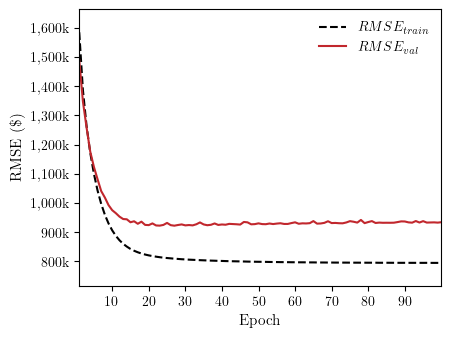

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

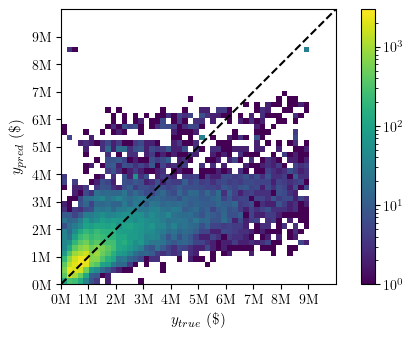

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')